<a href="https://colab.research.google.com/github/dR3AmZZ/MachineLearning/blob/main/facemaskdetection_yad2k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# if os.path.exists('/content/DataSet'):
#   print('Data set loaded Successfully')

Mounted at /content/drive



face mask detection - pictures & annotation
detect human face predict bouding box
yolov2

preprocessing input: true bounding box and mask
define anchor box
consturct network architecture
custom loss function

training process

keras implemetation


## Data loading & Module importing

In [2]:
!unzip -u '/content/drive/MyDrive/archive.zip' -d '/content/'

Archive:  /content/drive/MyDrive/archive.zip
  inflating: /content/annotations/maksssksksss0.xml  
  inflating: /content/annotations/maksssksksss1.xml  
  inflating: /content/annotations/maksssksksss10.xml  
  inflating: /content/annotations/maksssksksss100.xml  
  inflating: /content/annotations/maksssksksss101.xml  
  inflating: /content/annotations/maksssksksss102.xml  
  inflating: /content/annotations/maksssksksss103.xml  
  inflating: /content/annotations/maksssksksss104.xml  
  inflating: /content/annotations/maksssksksss105.xml  
  inflating: /content/annotations/maksssksksss106.xml  
  inflating: /content/annotations/maksssksksss107.xml  
  inflating: /content/annotations/maksssksksss108.xml  
  inflating: /content/annotations/maksssksksss109.xml  
  inflating: /content/annotations/maksssksksss11.xml  
  inflating: /content/annotations/maksssksksss110.xml  
  inflating: /content/annotations/maksssksksss111.xml  
  inflating: /content/annotations/maksssksksss112.xml  
  inflati

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/facemaskdetectionyolo/YAD2K')

# Model

Try to generate and train model on only 1 picture, to validate the model

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import matplotlib.patches as patches


In [5]:
import PIL

In [6]:
tf.compat.v1.executing_eagerly()

True

In [7]:
# define image, annotations store's path
image_path = '/content/images/'
annot_path = '/content/annotations/'
# sort file name in image, annotation directory
imgs = list(sorted(os.listdir("/content/images/")))
labels = list(sorted(os.listdir("/content/annotations/")))

## Single Sample Training set preprocessing

In [8]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

# Bounding box file path preprocessing
annotation_path = annot_path + labels[3]

In [9]:
# read png image as train set
# png image has 4 channels
test_image = Image.open(image_path + imgs[3])
test_image = test_image.convert("RGB")
orig_size = np.array([test_image.width, test_image.height])
orig_size = np.expand_dims(orig_size, axis = 0)

In [10]:
# read 1 xml file from directory and generate bouding box for that picture
# [class, xmin, ymin, xmax, ymax]
with open(annotation_path) as f:
    data = f.read()
    soup = BeautifulSoup(data, 'xml')
    objects = soup.find_all('object')
    
    nums_objects = len(objects)
    #
    boxes = []
    for obj in objects:
        box = []
        box.append(generate_label(obj))
        box.extend(generate_box(obj))
        boxes.append(box)
    boxes = np.array(boxes)

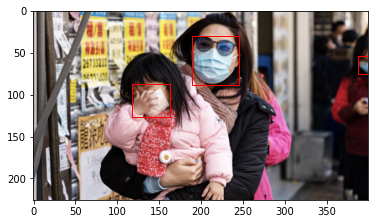

In [11]:
plt.imshow(test_image)
ax = plt.gca()
for bbox in boxes:
    rect = patches.Rectangle((bbox[1],bbox[2]), bbox[3]-bbox[1], bbox[4] - bbox[2] ,
                            linewidth = 1,
                             edgecolor='r',
                            facecolor = 'none')
    ax.add_patch(rect)


In [12]:
test_image = test_image.resize((416, 416), PIL.Image.BICUBIC)
image_data = np.array(test_image, dtype = np.float)
image_data /= 255.
# Input image size
image_size = image_data.shape
# class definiation
class_names = ["without_mask", "with_mask", "mask_weared_incorrect"]

In [13]:
# transform bounding box representation into [class,center:(x,y), width, height]
boxes_xy = (boxes[:, 3:5] + boxes[:, 1:3]) *.5
boxes_wh = boxes[:, 3:5] - boxes[:, 1:3]

# resize box
boxes_xy = boxes_xy / orig_size
boxes_wh = boxes_wh / orig_size

boxes = np.concatenate((boxes_xy, boxes_wh, boxes[:, 0:1]), axis = 1)

In [14]:
# image preprocessing
test_image = test_image.resize((416, 416))
image_data = np.array(test_image, dtype = np.float)
image_data /= 255.
# Input image size
image_size = image_data.shape
# class definiation
class_names = ["without_mask", "with_mask", "mask_weared_incorrect"]

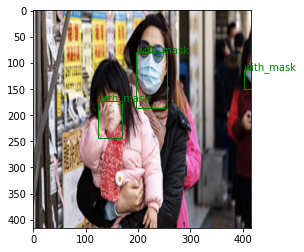

In [15]:
# plot
plt.imshow(test_image)
ax = plt.gca()
class_map = {1:['g','with_mask'], 2:['b','mask_weared_incorrect'], 3:['r','without_mask']}
for bbox in boxes:
    resize_xy = (bbox[:2] - .5 * bbox[2:3])*416
    resize_wh = bbox[2:4]*416
    color, text = class_map[bbox[4]]
    rect = patches.Rectangle(resize_xy, resize_wh[0], resize_wh[1],
                            linewidth = 1,
                             edgecolor = color,
                            facecolor = 'none')
    ax.add_patch(rect)
    plt.text(resize_xy[0], resize_xy[1], text, 
             fontsize = 10, color = color)
plt.show()    

In [16]:
def preprocess_true_boxes(true_boxes, anchors, image_size):
    """Find detector in YOLO where ground truth box should appear.

    Parameters
    ----------
    true_boxes : array
        List of ground truth boxes in form of relative x, y, w, h, class.
        Relative coordinates are in the range [0, 1] indicating a percentage
        of the original image dimensions.
    anchors : array
        List of anchors in form of w, h.
        Anchors are assumed to be in the range [0, conv_size] where conv_size
        is the spatial dimension of the final convolutional features.
    image_size : array-like
        List of image dimensions in form of h, w in pixels.

    Returns
    -------
    detectors_mask : array
        0/1 mask for detectors in [conv_height, conv_width, num_anchors, 1]
        that should be compared with a matching ground truth box.
    matching_true_boxes: array
        Same shape as detectors_mask with the corresponding ground truth box
        adjusted for comparison with predicted parameters at training time.
    """
    height, width = image_size
    num_anchors = len(anchors)
    # Downsampling factor of 5x 2-stride max_pools == 32.
    # based on the yolov2 architecture
    assert height % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    assert width % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    
    # 416 // 32 = 13
    # divide input into 13 X 13 grid cells
    conv_height = height // 32
    # 13
    conv_width = width // 32
    num_box_params = true_boxes.shape[1]
    detectors_mask = np.zeros(
        (conv_height, conv_width, num_anchors, 1), dtype=np.float32)
    matching_true_boxes = np.zeros(
        (conv_height, conv_width, num_anchors, num_box_params),
        dtype=np.float32)

    for box in true_boxes:
        # scale box to convolutional feature spatial dimensions
        # x,y,w,h in original input is from (0,1) because of the standarlization
        box_class = box[4:5]
        # scale the box to [0, 13] indicates which grid cell the truth box is in
        box = box[0:4] * np.array(
            [conv_width, conv_height, conv_width, conv_height])
        # x,y denotes center of bouding box which needs to be integer after scaling
        i = np.floor(box[1]).astype('int')
        j = np.floor(box[0]).astype('int')
        # we're expecting the output [13, 13, anchors, 1]
        # now [batch, h, w, anchors, 1] h = i, w = j
        # anchors has not been decided
        best_iou = 0
        best_anchor = 0
        for k, anchor in enumerate(anchors):
            # Find IOU between box shifted to origin and anchor box.
            # Suppose the center of true box and anchor box  are the same
            # transform (x, y, w, h) to (xmin, ymin), (xmax, ymax)
            # when (x,y) are the same for 2 boxes
            box_maxes = box[2:4] / 2.
            box_mins = -box_maxes
            anchor_maxes = (anchor / 2.)
            anchor_mins = -anchor_maxes

            intersect_mins = np.maximum(box_mins, anchor_mins)
            intersect_maxes = np.minimum(box_maxes, anchor_maxes)
            intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
            intersect_area = intersect_wh[0] * intersect_wh[1]
            box_area = box[2] * box[3]
            anchor_area = anchor[0] * anchor[1]
            iou = intersect_area / (box_area + anchor_area - intersect_area)
            if iou > best_iou:
                best_iou = iou
                best_anchor = k

        if best_iou > 0:
            detectors_mask[i, j, best_anchor] = 1
            adjusted_box = np.array(
                [
                    box[0] - j, box[1] - i,
                    np.log(box[2] / anchors[best_anchor][0]),
                    np.log(box[3] / anchors[best_anchor][1]), box_class
                ],
                dtype=np.float32)
            matching_true_boxes[i, j, best_anchor] = adjusted_box
    return detectors_mask, matching_true_boxes


In [17]:
# pre-define anchors
## !In the following procedure we are going to generate our own anchor boxes using k-means clustering 
anchors = np.array(
    ((0.57273, 0.677385), (1.87446, 2.06253), (3.33843, 5.47434),
     (7.88282, 3.52778), (9.77052, 9.16828))
    )

In [18]:
# matching true boxes give the regression targets for the ground truth box
# loss function in yolov2 are divided into 4 parts, object in anchor box, no object in anchor box and so on,
# here mask is used to select which predicted boxes are used to calculate loss

# select boxes used to calculate loss
detectors_mask_shape = (13, 13, 5, 1)
matching_boxes_shape = (13, 13, 5, 5)

detectors_mask, matching_true_boxes = preprocess_true_boxes(boxes, anchors,
                                                                [416, 416])

plot the annotation with photos after reshaping to test if box preprocessing and image preprocessing run correctly

## Training Set preprocessing

### Preprocessing true boxes

### Train-validation split

In [19]:
# Train-val split
datazip = list(zip(imgs,labels))
import numpy as np
np.random.seed(1)
np.random.shuffle(datazip)
# 
train_, val_ = datazip[:int(len(imgs) * .95)], datazip[int(len(imgs)* .95):]

In [20]:
# 
max_boxes = 115
image_data_set = []
true_boxes_set = []
i = 0
for image_file, annotation_file in train_:
  # read images
  # convert png to rgb, png has 4 channels, we want shape of picture like (a, a, 3)
  test_image = Image.open(image_path + image_file)
  orig_size = np.array([test_image.width, test_image.height])
  orig_size = np.expand_dims(orig_size, axis = 0)
  
  test_image = test_image.convert("RGB")
  test_image = test_image.resize((416, 416))
  image_data = np.array(test_image, dtype = np.float)
  image_data /= 255.
  image_data_set.append(image_data)

  # read annotation
  annotation_path = annot_path + annotation_file
  with open(annotation_path) as f:
    data = f.read()
    soup = BeautifulSoup(data, 'xml')
    objects = soup.find_all('object')
    
    nums_objects = len(objects)
    #
    boxes = []
    for obj in objects:
        box = []
        box.append(generate_label(obj))
        box.extend(generate_box(obj))
        boxes.append(box)
    boxes = np.array(boxes, dtype=np.float32)
    
    # Get box parameters as x_center, y_center, box_width, box_height, class.
    # transform bounding box representation into [class,center:(x,y), width, height]
    boxes_xy = (boxes[:, 3:5] + boxes[:, 1:3]) *.5
    boxes_wh = boxes[:, 3:5] - boxes[:, 1:3]

    # resize box for each picture's annotation
    boxes_xy = boxes_xy / orig_size
    boxes_wh = boxes_wh / orig_size

    boxes = np.concatenate((boxes_xy, boxes_wh, boxes[:, 0:1]), axis = 1)

    if boxes.shape[0]  < max_boxes:
      zero_padding = np.zeros( (max_boxes-boxes.shape[0], 5), dtype=np.float32)
      boxes = np.vstack((boxes, zero_padding))

    true_boxes_set.append(boxes)
# convert list to ndarray
image_data_set = np.array(image_data_set)
true_boxes_set = np.array(true_boxes_set)

In [21]:
true_boxes_set.shape

(810, 115, 5)

In [22]:
image_data_set.shape

(810, 416, 416, 3)

### Get detector mask for large sample

In [23]:
def get_detector_mask(boxes, anchors):
    '''
    Precompute detectors_mask and matching_true_boxes for training.
    Detectors mask is 1 for each spatial position in the final conv layer and
    anchor that should be active for the given boxes and 0 otherwise.
    Matching true boxes gives the regression targets for the ground truth box
    that caused a detector to be active or 0 otherwise.
    '''
    detectors_mask = [0 for i in range(len(boxes))]
    matching_true_boxes = [0 for i in range(len(boxes))]
    for i, box in enumerate(boxes):
        detectors_mask[i], matching_true_boxes[i] = preprocess_true_boxes(box, anchors, [416, 416])

    return np.array(detectors_mask), np.array(matching_true_boxes)

In [24]:
detectors_mask, matching_true_boxes = get_detector_mask(true_boxes_set, anchors)

In [25]:
detectors_mask.shape

(810, 13, 13, 5, 1)

In [26]:
matching_true_boxes.shape

(810, 13, 13, 5, 5)

### Anchor & conduct preprocessing

### preprocess_true_box function

generate detector mask and matching true box

## Constructing darknet architecture

In [27]:
from yad2k.models.keras_yolo import yolo_body
from yad2k.utils.draw_boxes import draw_boxes

In [28]:
from keras.layers import Input, Lambda, Layer
from keras.models import Model

In [29]:
# Create model input layers.
image_input = Input(shape=(416, 416, 3))
boxes_input = Input(shape=(None, 5))
detectors_mask_input = Input(shape=detectors_mask_shape)
matching_boxes_input = Input(shape=matching_boxes_shape)

In [30]:
# test detectors_mask
print("Active detectors:")
print(np.where(detectors_mask == 1)[:-1])

print('----')
# test matching_boxes_input
print("Matching boxes for active detectors:")
print(matching_true_boxes[np.where(detectors_mask == 1)[:-1]])

Active detectors:
(array([  0,   1,   1, ..., 807, 808, 809]), array([4, 1, 1, ..., 6, 1, 6]), array([ 5,  3, 11, ...,  2,  6,  6]), array([1, 0, 0, ..., 0, 2, 3]))
----
Matching boxes for active detectors:
[[ 0.02125     0.9756637   0.02270164  0.42781416  1.        ]
 [ 0.78625     0.8369565   0.07526467  0.6518797   1.        ]
 [ 0.245       0.3         0.22186814  0.7744821   1.        ]
 ...
 [ 0.73        0.9375      0.5320231   0.57875746  1.        ]
 [ 0.38625     0.6755555  -0.12115632 -0.5258711   1.        ]
 [ 0.045       0.8575     -0.13461462  0.5057729   1.        ]]


In [31]:
from yad2k.models.keras_yolo import yolo_body

In [32]:
# import yolo body
model_body = yolo_body(image_input, len(anchors), len(class_names))

In [33]:
model_body = yolo_body(image_input, len(anchors), len(class_names))
topless_yolo = Model(model_body.input, model_body.layers[-2].output)

In [34]:
topless_yolo_path = os.path.join('model_data', 'yolo_topless.h5')
if not os.path.exists(topless_yolo_path):
  print("CREATE TOPLESS")

CREATE TOPLESS


In [35]:
# make yolo body except for loss layer
model_body = Model(image_input, model_body.output)

Before concatenate layer, YOLOv2 trained on different dataset share the same feature extracting architecture, we can use pre-trained model to accelerate learning process

In [36]:
model_body.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 416, 416, 32  128        ['conv2d_23[0][0]']              
 ormalization)                  )                                                           

## Custom YOLOv2 loss

yolov2 loss function takes the y_pred: 13X13X24 volume(output of architecture extracting net), 

y_true: true_boxes,

detected_mask: specifiy which anchor box to calculate loss,

matching_true_boxes: the label of part of picture, 

4 arguments as input. with anchors and classes information

To implement yolo loss, we custom a layer and put it in the whole model, which takes 4 inputs from former layers or input.




In [37]:
import keras.backend as K
from yad2k.models.keras_yolo import yolo_head

class yolo_loss_layer(Layer):
    def __init__(self, anchors, classes):
        """
        
        anchors : tensor
            Anchor boxes for model.

        num_classes : int
            Number of object classes.
        """
        
        super(yolo_loss_layer, self).__init__()

        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.anchor_tensor = K.reshape(K.variable(anchors), [1, 1, 1, 5, 2])
        self.num_classes = len(classes)

    #args = [input_tensor, true_boxes, detectors_mask, matching_true_box]
    def call(self, input_tensor, true_boxes, detectors_mask, matching_true_box):
        """
        yolo_output : tensor
            Final convolutional layer features.

        true_boxes : tensor
            Ground truth boxes tensor with shape [batch, num_true_boxes, 5]
            containing box x_center, y_center, width, height, and class.

        detectors_mask : tensor
            0/1 mask for detector positions where there is a matching ground truth.

        matching_true_boxes : tensor
            Corresponding ground truth boxes for positive detector positions.
            Already adjusted for conv height and width.
        """
        yolo_output, true_boxes, detectors_mask, matching_true_boxes = input_tensor, true_boxes, detectors_mask, matching_true_box
        num_anchors = self.num_anchors

        object_scale = 5
        no_object_scale = 1
        class_scale = 1
        coordinates_scale = 1
        #
        pred_xy, pred_wh, pred_confidence, pred_class_prob = yolo_head(
        yolo_output, self.anchor_tensor, self.num_classes, self.num_anchors)
        
        # Unadjusted box predictions for loss.
        yolo_output_shape = K.shape(yolo_output)
        feats = K.reshape(yolo_output, [
            -1, yolo_output_shape[1], yolo_output_shape[2], num_anchors,
            self.num_classes + 5
        ])
        pred_boxes = K.concatenate(
            (K.sigmoid(feats[..., 0:2]), feats[..., 2:4]), axis=-1)


        # Expand pred x,y,w,h to allow comparison with ground truth.
        # batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params
        pred_xy = K.expand_dims(pred_xy, 4)
        pred_wh = K.expand_dims(pred_wh, 4)

        pred_wh_half = pred_wh / 2.
        pred_mins = pred_xy - pred_wh_half
        pred_maxes = pred_xy + pred_wh_half

        true_boxes_shape = K.shape(true_boxes)

        # batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params
        true_boxes = K.reshape(true_boxes, [
            true_boxes_shape[0], 1, 1, 1, true_boxes_shape[1], true_boxes_shape[2]
        ])
        true_xy = true_boxes[..., 0:2]
        true_wh = true_boxes[..., 2:4]

        # Find IOU of each predicted box with each ground truth box.
        true_wh_half = true_wh / 2.
        true_mins = true_xy - true_wh_half
        true_maxes = true_xy + true_wh_half

        intersect_mins = K.maximum(pred_mins, true_mins)
        intersect_maxes = K.minimum(pred_maxes, true_maxes)
        intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
        true_areas = true_wh[..., 0] * true_wh[..., 1]

        union_areas = pred_areas + true_areas - intersect_areas
        iou_scores = intersect_areas / union_areas

        # Best IOUs for each location.
        best_ious = K.max(iou_scores, axis=4)  # Best IOU scores.
        best_ious = K.expand_dims(best_ious)

        # A detector has found an object if IOU > thresh for some true box.
        object_detections = K.cast(best_ious > 0.6, K.dtype(best_ious))

        # Determine confidence weights from object and no_object weights.
        no_object_weights = (no_object_scale * (1 - object_detections) *
                             (1 - detectors_mask))
        no_objects_loss = no_object_weights * K.square(-pred_confidence)


        # Loss calculation
        # Confidence loss for object prediction
        
        objects_loss = (object_scale * detectors_mask *
                            K.square(1 - pred_confidence))
        confidence_loss = objects_loss + no_objects_loss

        # Classification loss for matching detections.

        matching_classes = K.cast(matching_true_boxes[..., 4], 'int32')
        matching_classes = K.one_hot(matching_classes, self.num_classes)
        classification_loss = (class_scale * detectors_mask *
                               K.square(matching_classes - pred_class_prob))

        # Coordinate loss for matching detection boxes.
        matching_boxes = matching_true_boxes[..., 0:4]
        coordinates_loss = (coordinates_scale * detectors_mask *
                            K.square(matching_boxes - pred_boxes))

        confidence_loss_sum = K.sum(confidence_loss)
        classification_loss_sum = K.sum(classification_loss)
        coordinates_loss_sum = K.sum(coordinates_loss)
        total_loss = 0.5 * (
            confidence_loss_sum + classification_loss_sum + coordinates_loss_sum)
        
        return total_loss

## Model training

In [38]:
# add yolo_loss layer into Model
from tensorflow.keras.optimizers import Adam

# connect yolo loss layer to model
yolo_loss_output = yolo_loss_layer(anchors, class_names)(input_tensor = model_body.output, 
                                                         true_boxes = boxes_input, 
                                                         detectors_mask = detectors_mask_input, 
                                                         matching_true_box = matching_boxes_input)
# construct model
model = Model(
        [image_input, boxes_input, detectors_mask_input,
         matching_boxes_input], yolo_loss_output)

# define optimizer and compile model
optimizer = Adam(learning_rate=1e-4)
# compile
model.compile(
    optimizer=optimizer, loss = {'yolo_loss_layer': lambda y_true, y_pred:y_pred}
    )

In [39]:
# # Add batch dimension for training.
# image_data = np.expand_dims(image_data, axis=0)
# boxes = np.expand_dims(boxes, axis=0)
# detectors_mask = np.expand_dims(detectors_mask, axis=0)
# matching_true_boxes = np.expand_dims(matching_true_boxes, axis=0)
# print(image_data.shape)
# print(boxes.shape)
# print(detectors_mask.shape)
# print(matching_true_boxes.shape)

(1, 416, 416, 3)
(1, 115, 5)
(1, 810, 13, 13, 5, 1)
(1, 810, 13, 13, 5, 5)


In [40]:
# # delete batch dimension.
# image_data = np.squeeze(image_data, axis=0)
# boxes = np.squeeze(boxes, axis=0)
# detectors_mask = np.squeeze(detectors_mask, axis=0)
# matching_true_boxes = np.squeeze(matching_true_boxes, axis=0)
# print(image_data.shape)
# print(boxes.shape)
# print(detectors_mask.shape)
# print(matching_true_boxes.shape)

(416, 416, 3)
(115, 5)
(810, 13, 13, 5, 1)
(810, 13, 13, 5, 5)


 ValueError: Exception encountered when calling layer "yolo_loss_layer" (type yolo_loss_layer).
    
    in user code:
    
        File "<ipython-input-26-c1020ab35799>", line 42, in call  *
            pred_xy, pred_wh, pred_confidence, pred_class_prob = yolo_head(
        File "/content/drive/MyDrive/facemaskdetectionyolo/YAD2K/yad2k/models/keras_yolo.py", line 92, in yolo_head  *
            anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])
        File "/usr/local/lib/python3.7/dist-packages/keras/backend.py", line 1069, in variable  **
            constraint=constraint)
    
        ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


In [41]:
epochs = 10
# already know how to add loss layer and train model
model.fit([image_data_set, true_boxes_set, detectors_mask, matching_true_boxes],
          np.zeros(shape=(810,)),
          batch_size=1,
          epochs = epochs)

Epoch 1/10
810/810 [==============================] - 151s 170ms/step - loss: 25.9168
Epoch 2/10
 42/810 [>.............................] - ETA: 2:10 - loss: 14.8721

KeyboardInterrupt: ignored

In [ ]:
# 
predict_output = model_body.predict(image_data,
              batch_size = 1)

In [ ]:
anchor_tensor = K.reshape(K.variable(anchors), [1, 1, 1, 5, 2])

In [ ]:
a = tf.convert_to_tensor(predict_output)

In [ ]:
yolo_head_output = yolo_head(a, anchors_tensor=anchor_tensor,
          num_classes=len(class_names), num_anchors=len(anchors))

In [ ]:
from yad2k.models.keras_yolo import yolo_head,yolo_eval

In [ ]:
image_input

In [ ]:
boxes, scores, classes = yolo_eval(yolo_head_output, (416.0, 416.0)
                                   , score_threshold =.17)

In [ ]:
boxes

``` python
sess = K.get_session()
out_boxes, out_scores, out_classes = sess.run(
    [boxes, scores, classes],
    feed_dict = {
        model_body.input: image_data,
        input_image_shape: [image_size[1], image_size[0]],
        K.learning_phase(): 0
    }
)
print('Found {} boxes for image.'.format(len(out_boxes)))
print(out_boxes)

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-33-0a8b1480dcb5> in <module>()
      5         model_body.input: image_data,
      6         input_image_shape: [image_size[1], image_size[0]],
----> 7         K.learning_phase(): 0
      8     }
      9 )

/usr/local/lib/python3.7/dist-packages/keras/engine/keras_tensor.py in __hash__(self)
    240 
    241   def __hash__(self):
--> 242     raise TypeError(f'Tensors are unhashable (this tensor: {self}). '
    243                     'Instead, use tensor.ref() as the key.')
    244 

TypeError: Tensors are unhashable (this tensor: KerasTensor(type_spec=TensorSpec(shape=(None, 416, 416, 4), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")). Instead, use tensor.ref() as the key.

```

In [ ]:
"""Draw predicted or ground truth boxes on input image."""

import colorsys
import random

import numpy as np
from PIL import Image, ImageDraw, ImageFont


def get_colors_for_classes(num_classes):
    """Return list of random colors for number of classes given."""
    # Use previously generated colors if num_classes is the same.
    if (hasattr(get_colors_for_classes, "colors") and
            len(get_colors_for_classes.colors) == num_classes):
        return get_colors_for_classes.colors

    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    get_colors_for_classes.colors = colors  # Save colors for future calls.
    return colors


def draw_boxes(image, boxes, box_classes, class_names, scores=None):
    """Draw bounding boxes on image.

    Draw bounding boxes with class name and optional box score on image.

    Args:
        image: An `array` of shape (width, height, 3) with values in [0, 1].
        boxes: An `array` of shape (num_boxes, 4) containing box corners as
            (y_min, x_min, y_max, x_max).
        box_classes: A `list` of indicies into `class_names`.
        class_names: A `list` of `string` class names.
        `scores`: A `list` of scores for each box.

    Returns:
        A copy of `image` modified with given bounding boxes.
    """
    image = Image.fromarray(np.floor(image * 255 + 0.5).astype('uint8'))

    font = ImageFont.load_default()
    thickness = (image.size[0] + image.size[1]) // 300

    colors = get_colors_for_classes(len(class_names))

    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]
        if isinstance(scores, np.ndarray):
            score = scores[i]
            label = '{} {:.2f}'.format(box_class, score)
        else:
            label = '{}'.format(box_class)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
       # draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return np.array(image)


In [ ]:
a= np.array(image)
plt.imshow(a)

In [ ]:
#from yad2k.utils.draw_boxes import draw_boxes
img_with_box = draw_boxes(image_data[0], boxes, classes, class_names, scores)

In [ ]:
plt.imshow(img_with_box)

In [ ]:
image = image_data[0]

In [ ]:
font = ImageFont.truetype(
    font='font/FiraMono-Medium.otf',
    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))